#  Analysis Template tutorial

In [1]:
protein_name="protein"
author='A. Emerson'

In [2]:
# load image here in markdown format

In [3]:
import datetime

x = datetime.datetime.now()
print('Analysis started '+x.strftime("%c"))
print('Author '+author)

Analysis started Tue Mar 16 13:17:38 2021
Author A. Emerson


In [4]:
import socket
print("Analysis computer="+socket.gethostname())


Analysis computer=NAEMERSON204042


In [5]:
# Python module imports

In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [8]:
%matplotlib inline

In [9]:
import os

In [10]:
from subprocess import Popen, PIPE, STDOUT

In [11]:
import os.path
from os import path

In [12]:
import pandas as pd

### MD Analysis modules

In [13]:
import MDAnalysis as mda

In [14]:
from MDAnalysis.analysis import rms, align, pca

In [15]:
import nglview as nv

In [ ]:
### EX4C Library

In [ ]:
from EX4Cutils import *

### File definition

In [17]:
#datadir="/m100_scratch/userinternal/aemerson/Exscalate4Cov/nsp16/"# end with a /
datadir="/home/aemerson/desktop/Exscalate4Cov/analysis/test_data/"

In [18]:
%cd /home/aemerson/desktop/Exscalate4Cov/analysis/test_data/

/mnt/c/Users/aem0/Desktop/Exscalate4Cov/analysis/test_data


In [19]:
# pre-processing if necessary
# gmx trjconv -s tpr -f xto.xtc -o xtc -center -pbc mol -ur compact
# gmx trjconv -s tpr -f xtc -o start.pdb -dump 0

In [20]:
xtc=datadir+'nsp2-50.xtc' # I have used a reduced xtc with trjconv -skip 10
tpr=datadir+'topol.tpr'
pdb=datadir+'nsp2.pdb'

In [21]:
index=datadir+'index.ndx'  # must exist

In [22]:
# check files
filelist=[xtc,tpr,pdb,index]  # add index.ndx if necessary
test_files(filelist)

## Show protein with nglview

In [23]:
u = mda.Universe(pdb)
protein = u.select_atoms('protein')
domain_view = nv.show_mdanalysis(u)
domain_view.color_by('chainID')
domain_view

NGLWidget()

In [24]:
## save as image
domain_view.render_image()
domain_view._display_image()

In [25]:
# save image
domain_view.render_image()
domain_view.download_image(filename=protein_name+'.png', factor=4, trim=True)

## Load trajectory and show

In [26]:
u = mda.Universe(pdb,xtc,in_memory=True )

In [27]:
print("Trajectory length="+str(len(u.trajectory))+" frames. ")
print("Atoms="+str(len(u.atoms)))

Trajectory length=3600 frames. 
Atoms=9923


In [28]:
calpha=u.select_atoms("name CA")
protein = u.select_atoms('protein')

In [29]:
w = nv.show_mdanalysis(protein)
w

NGLWidget(max_frame=3599)

## Radius of gyration

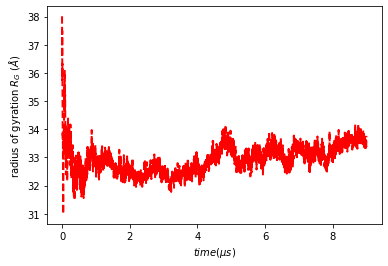

In [30]:
Rgyr = []
protein = u.select_atoms("protein")
for ts in u.trajectory:
   Rgyr.append((u.trajectory.time, protein.radius_of_gyration()))
Rgyr = np.array(Rgyr)

# plot 
ax = plt.subplot(111)
ax.plot(Rgyr[:,0], Rgyr[:,1], 'r--', lw=2, label=r"$R_G$")
ax.set_xlabel(r'$time (\mu s)$')
ax.set_ylabel(r"radius of gyration $R_G$ ($\AA$)")
scale_x = 1e-6
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale_x))
ax.xaxis.set_major_formatter(ticks_x)

plt.draw()

### RMSD of trajectory

In [31]:
r=rms.RMSD(u,u,select="backbone",ref_frame=0)

In [32]:
r.run()

In [33]:
df_rmsd=pd.DataFrame(r.rmsd,columns=['Frame','Time(ps)','Backbone'])

In [34]:
df_rmsd=df_rmsd[:-1] # remove last row (empty)

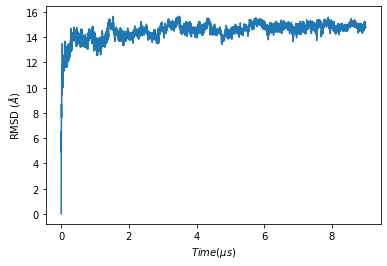

In [35]:
# adjust the xlim in the plots so as to estimate the frames to discard for analysis (i.e. start)
ax=plt.subplot(111)

ax.plot(df_rmsd['Time(ps)'],df_rmsd['Backbone'])
ax.set_ylabel(r'RMSD ($\AA$)')
ax.set_xlabel(r'$Time(\mu s)$')
## scale x axis to give microseconds
scale_x = 1e-6
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale_x))
ax.xaxis.set_major_formatter(ticks_x)



In [36]:
# equilibration cutoffs from above
start='200000' # 200ns

## RMSF 

Text(0.5, 1.0, 'RMSF')

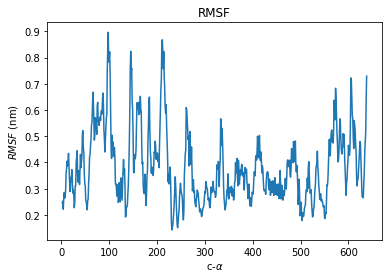

In [37]:
#  Gromacs
options=GMX_CALPHA
rmsf='rmsf.xvg'
df = gmx_rmsf(xtc,tpr,rmsf,options)
ax = plt.subplot(111)
ax.plot(df['x'],df['y'])
ax.set_xlabel(r"c-$\alpha$")
ax.set_ylabel(r"$RMSF$ (nm)")
ax.set_title('RMSF')

In [38]:
# VIA MDAnalysis - only if memory available
#calphas=rmsf(u,pdb)
#rmsfer = mda.analysis.rms.RMSF(calphas).run()
#ax = plt.subplot(111)
#ax.plot(calphas.resnums, rmsfer.rmsf)
#ax.set_xlabel(r"c-$\alpha$")
#ax.set_ylabel(r"$RMSF$ ($\AA$)") # check units

In [39]:
## PCA analysis

In [40]:
#aligner=align.AlignTraj(u,u,select='backbone',in_memory=True).run()   # align trajectory in_memory=True for in memory

In [41]:
#pc=pca.PCA(u,select='backbone',align=False,mean=None,n_components=None).run() # this step is slow

In [42]:
#print(pc.p_components.shape)

In [43]:
backbone=u.select_atoms('backbone')
calpha=u.select_atoms('name CA')

## GROMACS PCA and cluster Analysis

In [44]:
##  PCA  via Gromacs
# 1. find covariance matrix -> eigenvec.trr, eigenval.xvg
# 2. project onto eigenvec.trr -> Firstplane.xvg

# May take some time
#options='3\n3'  # 3 =c-alpha, input here twice
options=GMX_CALPHA+"\n"+GMX_CALPHA
eigenvec='eigenvec.trr'
gmx_covar(xtc,tpr,start,eigenvec,options)
df_pca=gmx_anaeig(xtc,tpr,start,eigenvec,options)

<AxesSubplot:title={'center':'PCA'}, xlabel='[x]', ylabel='[y]'>

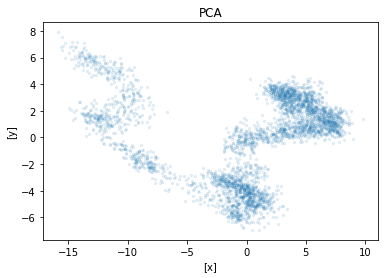

In [45]:

df_pca.plot(x=['x'],y=['y'],s=5,alpha=0.1,marker='o',kind='scatter',title='PCA')


## Cluster Analysis

In [46]:
# cluster analysis
# outputs:
# - clindex   index of frames for each cluster
# - cluster.log
# This takes some time

# GMX command line
# "gmx cluster -n ../newdyn/prt+zn.ndx -cutoff 0.2 -b 400000.0 -f
#traj.xtc  -s ../topol.tpr -method gromos -o -g -dist -ev -sz -cl
#cluster.xtc -wcl 3 -clndx"


#options='3\n3'  # c-alpha, c-alpha
options=GMX_CALPHA+"\n"+GMX_CALPHA
skip='5'  # adjust as necessary
clindex='clusters.ndx'
df=gmx_cluster(xtc,tpr,index,start,skip,clindex,options)
print("Clusters found="+str(len(df.index)))
# use only first 10
df=df[:10]

Clusters found=115


<AxesSubplot:title={'center':'APO'}, xlabel='x'>

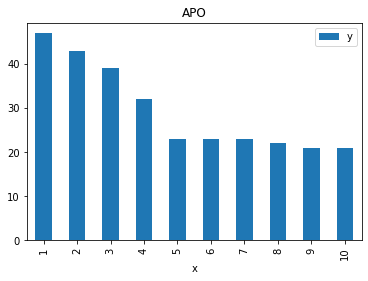

In [47]:
# plot
df.plot(x='x',y='y',kind='bar',title='APO',xlim=[1,5])

In [48]:
#![title](rmsd-clust.png)

In [49]:
# use the index created by gmx cluster to extract frames from original trajectory

# "gmx extract-cluster -f traj.xtc -s topol.tpr -clusters clusters.ndx
# -n ../newdyn/prt+zn.ndx"
#cmd=['gmx','extract-cluster','-f',xtc_apo,'-s',tpr_apo ,'-n',index,'-clusters','clusters.ndx']

options=GMX_CALPHA+'\n'+GMX_CALPHA
prefix='trajout'
clindex='clusters.ndx'
gmx_extract_cluster(xtc,tpr,index,clindex,prefix,options)

In [50]:
# We can now project these on the eigenvectors obtained from the original PCA analysis
## loop over selected trajectories


### 
prefix='trajout'
ncluster=5   ## adjust as necessary
xtc_list=[]
for i in range(1,ncluster+1):
    xtc_cluster=prefix+"_Cluster_{:0>4}".format(i)+".xtc"
    #print(xtc_cluster)
    df=gmx_anaeig(xtc_cluster,tpr,start,eigenvec,options,xvg='FirstPlane.xvg')
    xtc_list.append(df)
if (len(df.index)==0):
    print("Problem with gmx_anaeig")


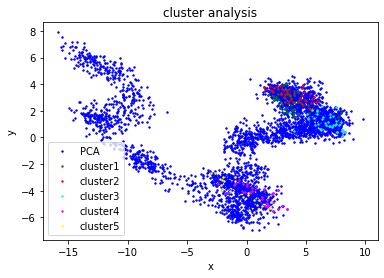

In [51]:
colors=['green','red','cyan','magenta','yellow','black']

# PCA
plt.scatter(df_pca['x'],df_pca['y'],s=2,marker='o',color='blue',label='PCA')

# clusters
i=0
for df in xtc_list:
    i=i+1   
    plt.scatter(df['x'],df['y'],s=2,marker='o', color=colors[i-1], label='cluster'+format(i))
    plt.title("cluster analysis")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(loc='lower left')


## Cluster times imposed on RMSD

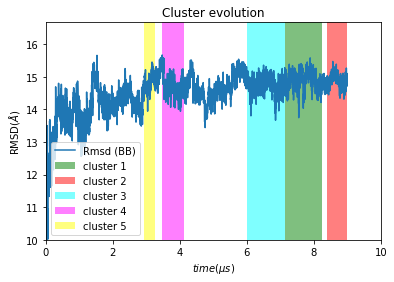

In [52]:
# Now read the cluster.log and get the times associated with each cluster
# superimpoe these on the RMSD
colors=['green','red','cyan','magenta','yellow','black']
max_clusters=5
cluster_times=get_cluster('cluster.log',max_clusters)

ax=plt.subplot(111)
height=np.max(df_rmsd['Backbone'])+1.0
for cluster in np.arange(0,max_clusters):
    time_points=cluster_times[cluster]
    c_mean=np.mean(time_points) # center of each bar
    c_max=np.max(time_points)
    c_min=np.min(time_points)
    bar_width=c_max-c_min
    ax.bar(c_mean, height,width=bar_width,alpha=0.5,facecolor=colors[cluster],label='cluster '+str(cluster+1))
df_rmsd.plot(ax=ax,x='Time(ps)',y='Backbone',kind='line',title='RMSD',label='Rmsd (BB)')
    
    
plt.xlabel(r'$time(\mu s)$')
plt.ylabel(r'RMSD($\AA$)')
plt.title('Cluster evolution')
plt.legend(loc='lower left')
ax.set_xlim(0,10000000)
ax.set_ylim(10,height)
# scale x-axis
scale_x = 1e-6
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale_x))
ax.xaxis.set_major_formatter(ticks_x)
plt.savefig('RMSD-cluster.png')


In [53]:
x = datetime.datetime.now()
print('Analysis finished '+x.strftime("%c"))

Analysis finished Tue Mar 16 13:19:23 2021
